### Load VBR Dataset and calibration parameters

In [2]:
### LOAD DATASET AND CALIBRATION FILE 

from my_utils.my_vbr_dataset import vbrDataset, load_calibration, generate_depth_and_scene_maps
from my_utils.mast3r_utils import get_master_output, get_mast3r_image_shape, scale_intrinsics, overlap
import cv2

dataset = vbrDataset(
    '/datasets/vbr_slam/spagna/spagna_train0_kitti', #path to dataset in kitti format
    '/datasets/vbr_slam/spagna/spagna_train0/spagna_train0_gt.txt' #path to ground truth file
)


In [3]:
print(len(dataset))

42435


Available queries: [4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450]... (showing first 10)
Available anchors: [600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050]... (showing first 10)
Total queries: 369, Total anchors: 142


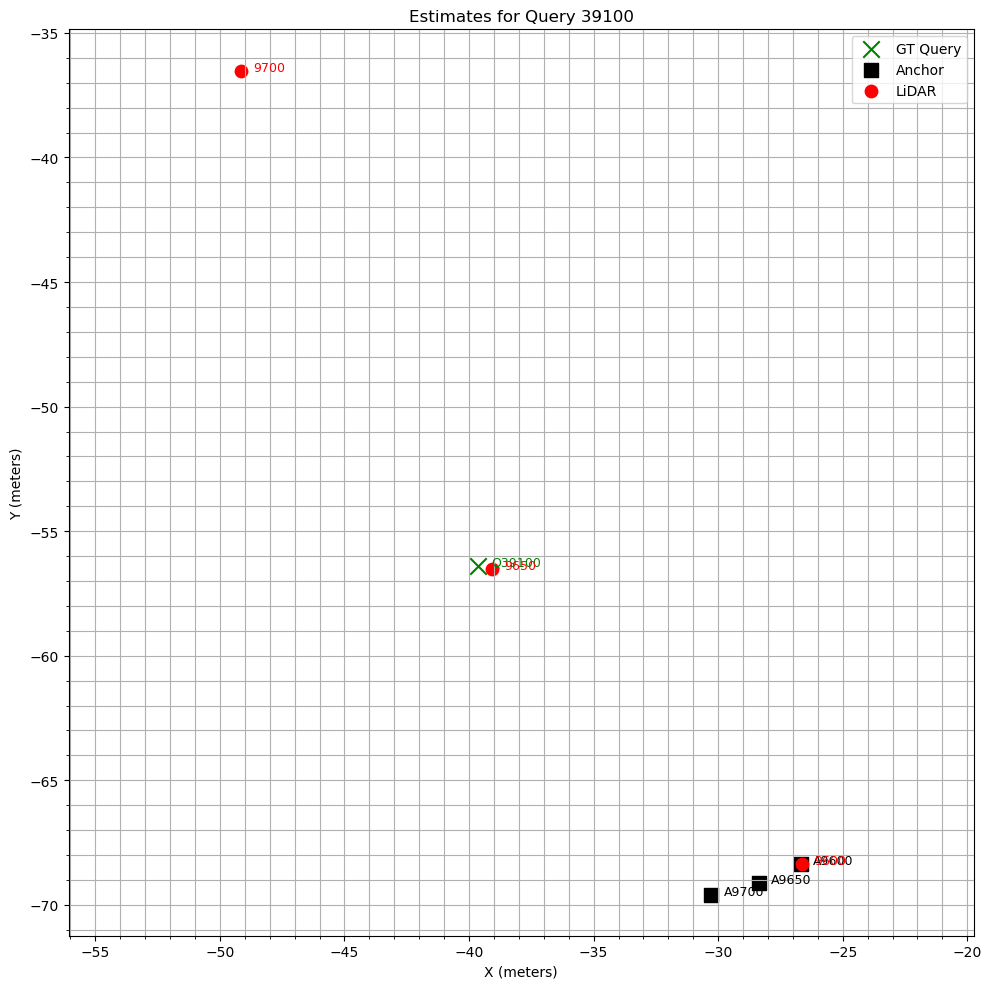

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from my_utils.plotting import load_pose_results, plot_all_estimates_for_query

def plot_pose_estimates(query_idx=None, anchor_idx=None, methods=None, show_all_for_query=False):
    """
    Plot pose estimates for different methods
    
    Args:
        query_idx: Specific query index (required)
        anchor_idx: Specific anchor index (optional, if None shows all anchors for query)
        methods: List of methods to plot (default: all methods)
        show_all_for_query: If True, show all estimates for the query regardless of anchor_idx
    """
    
    # Load all results using your existing function
    method_files = {
        "MASt3R": "results_step50/spagna_mast3r.txt",
        "LiDAR": "results_step50/spagna_lidar.txt",
        "Scaled V3": "results_step50/spagna_mast3r_scaled_v3.txt",
        "Scaled V4": "results_step50/spagna_mast3r_scaled_v4.txt",
        "Scaled V5": "results_step50/spagna_mast3r_scaled_icp.txt",
    }
    
    if methods is None:
        methods = list(method_files.keys())
    
    # Define styles for each result type
    styles = {
        "MASt3R": {'anchor': 'black', 'estimate': 'blue'},
        "LiDAR": {'anchor': 'black', 'estimate': 'red'},
        "Scaled V3": {'anchor': 'black', 'estimate': 'cyan'},
        "Scaled V4": {'anchor': 'black', 'estimate': 'brown'},
        "Scaled V5": {'anchor': 'black', 'estimate': 'orange'},
    }
    
    # Group results by query using your existing logic
    def group_by_query(rows):
        """Group rows by query index, filtering out NaN poses"""
        d = defaultdict(list)
        if len(rows) == 0:
            return d
        
        for row in rows:
            # Skip if any pose value is NaN
            if any(isinstance(x, float) and np.isnan(x) for x in row[2:]):
                continue
            query_idx, anchor_idx = int(row[0]), int(row[1])
            pose = row[2:]  # [x, y, z, qx, qy, qz, qw]
            d[query_idx].append((anchor_idx, pose))
        return d
    
    # Load and group all results
    all_results_dicts = {}
    for method in methods:
        if method in method_files:
            pose_rows = load_pose_results(method_files[method])
            grouped_data = group_by_query(pose_rows)
            all_results_dicts[method] = (grouped_data, styles[method])
    
    # Check if we have data for the query
    if query_idx is not None:
        total_estimates = 0
        for method, (grouped_data, _) in all_results_dicts.items():
            if query_idx in grouped_data:
                estimates = grouped_data[query_idx]
                # Filter by anchor if specified and not showing all
                if anchor_idx is not None and not show_all_for_query:
                    estimates = [(a_idx, pose) for a_idx, pose in estimates if a_idx == anchor_idx]
                total_estimates += len(estimates)
        
        if total_estimates == 0:
            print(f"No estimates found for query {query_idx}" + 
                  (f" and anchor {anchor_idx}" if anchor_idx is not None and not show_all_for_query else ""))
            return {}
        
        # If showing all for query, use your existing function
        if show_all_for_query or anchor_idx is None:
            plot_all_estimates_for_query(query_idx, dataset, all_results_dicts, styles)
        else:
            # For specific anchor-query pair, create a filtered version
            filtered_results = {}
            for method, (grouped_data, style) in all_results_dicts.items():
                if query_idx in grouped_data:
                    filtered_estimates = [(a_idx, pose) for a_idx, pose in grouped_data[query_idx] 
                                        if a_idx == anchor_idx]
                    if filtered_estimates:
                        filtered_grouped = {query_idx: filtered_estimates}
                        filtered_results[method] = (filtered_grouped, style)
            
            if filtered_results:
                plot_all_estimates_for_query(query_idx, dataset, filtered_results, styles)
    else:
        print("query_idx is required")
        return {}
    
    # return all_results_dicts

# Debug function to check available data
def check_available_data():
    """Check what data is available"""
    pose_file = "results_step50/spagna_mast3r.txt"
    pose_rows = load_pose_results(pose_file)
    
    if len(pose_rows) > 0:
        queries = sorted(set(int(row[0]) for row in pose_rows))
        anchors = sorted(set(int(row[1]) for row in pose_rows))
        print(f"Available queries: {queries[:10]}... (showing first 10)")
        print(f"Available anchors: {anchors[:10]}... (showing first 10)")
        print(f"Total queries: {len(queries)}, Total anchors: {len(anchors)}")
        
        # # Show some example pairs
        # pairs = [(int(row[0]), int(row[1])) for row in pose_rows[:5]]
        # print(f"Example pairs: {pairs}")
    else:
        print("No pose data found!")

# Usage examples:
check_available_data()

query_idx = 39100
anchor_idx = 9700
# Plot all estimates for a specific query
# plot_pose_estimates(query_idx, show_all_for_query=True)

# # Plot estimates for a specific anchor-query pair
# plot_pose_estimates(query_idx, anchor_idx)

# Plot only specific methods for a query
plot_pose_estimates(query_idx, methods=["LiDAR"], show_all_for_query=True)

Showing query 20100 with 6 anchors (sorted by num_inliers)


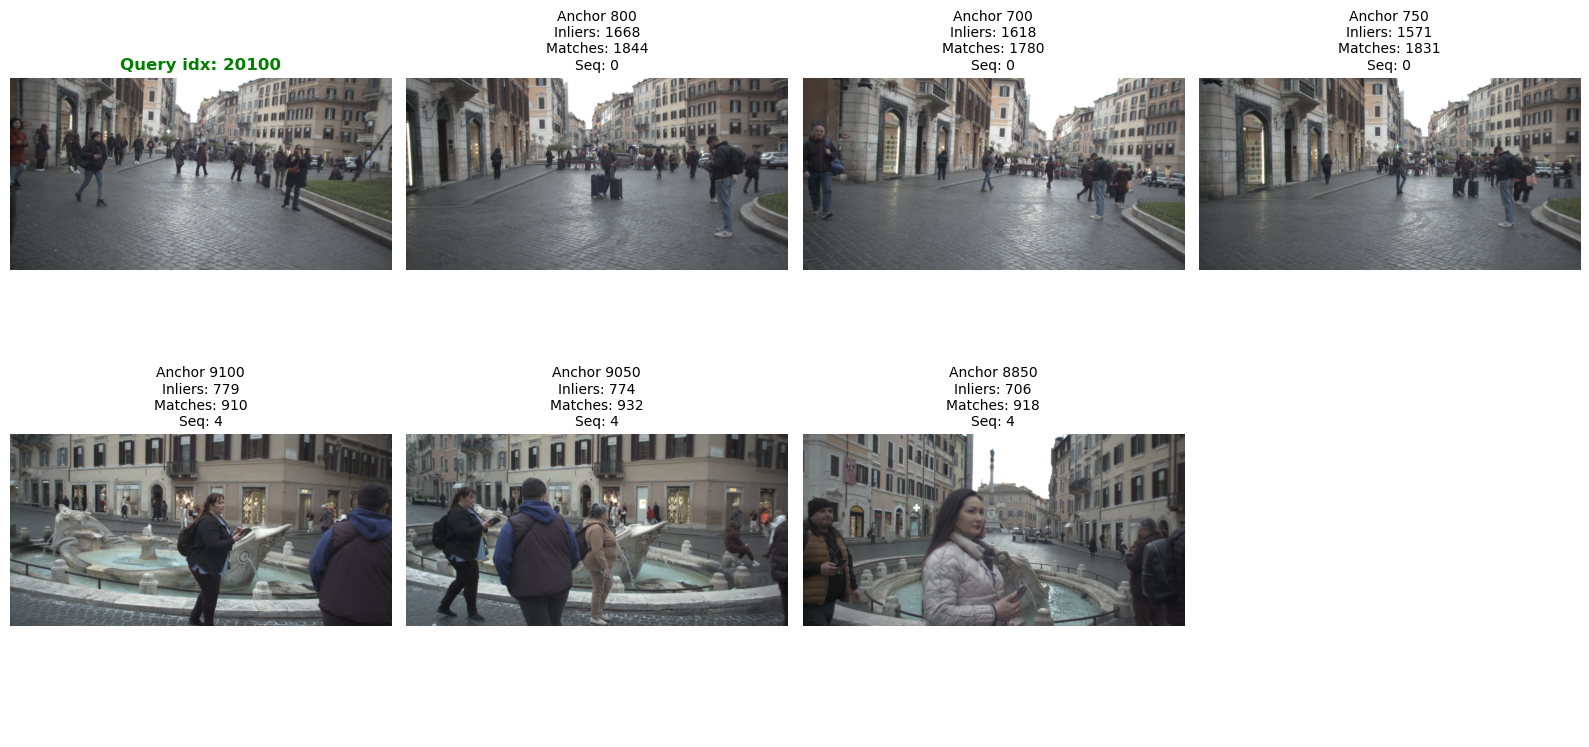


Summary for query 20100:
  Number of anchors: 6
  Inliers range: 706 - 1668
  Matches range: 910 - 1844
  Anchor sequences: 2 unique


In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Load CSV with top3 anchors per query
top3_df = pd.read_csv('/home/bjangley/VPR/mast3r-v2/mined_step50/spagna_matches_inliers_fm_top3_anchors_per_query_per_anchorseq.csv')


def show_all_anchors_for_query(query_idx, max_anchors=10, sort_by='num_inliers'):
    """
    Show query image and all its anchor images
    
    Args:
        query_idx: Query index to show
        max_anchors: Maximum number of anchors to display (default: 10)
        sort_by: Sort anchors by 'num_inliers', 'num_matches', or None (default: 'num_inliers')
    """
    
    # Get all anchors for this query
    anchors_for_query = top3_df[top3_df['query_idx'] == query_idx]
    
    if len(anchors_for_query) == 0:
        print(f"No anchors found for query {query_idx}")
        return
    
    # Sort if requested
    if sort_by and sort_by in anchors_for_query.columns:
        anchors_for_query = anchors_for_query.sort_values(sort_by, ascending=False)
    
    # Limit number of anchors
    anchors_for_query = anchors_for_query.head(max_anchors)
    n_anchors = len(anchors_for_query)
    
    print(f"Showing query {query_idx} with {n_anchors} anchors (sorted by {sort_by})")
    
    # Calculate grid layout
    n_cols = min(4, n_anchors + 1)  # Max 4 columns
    n_rows = int(np.ceil((n_anchors + 1) / n_cols))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    
    # Handle single row case
    if n_rows == 1:
        axs = np.array([axs]).flatten()
    else:
        axs = axs.flatten()
    
    # Display query image
    query_data = dataset[query_idx]
    query_img = Image.open(query_data['image_left'])
    axs[0].imshow(query_img)
    axs[0].set_title(f"Query idx: {query_idx}", fontsize=12, weight='bold', color='green')
    axs[0].axis('off')
    
    # Show anchor images
    for i, (_, row) in enumerate(anchors_for_query.iterrows()):
        anchor_idx = row['anchor_idx']
        anchor_data = dataset[anchor_idx]
        anchor_img = Image.open(anchor_data['image_left'])
        
        axs[i+1].imshow(anchor_img)
        title = f"Anchor {anchor_idx}\n"
        title += f"Inliers: {row['num_inliers']}\n"
        title += f"Matches: {row['num_matches']}"
        
        # Add sequence info if available
        if 'anchor_seq' in row:
            title += f"\nSeq: {row['anchor_seq']}"
        
        axs[i+1].set_title(title, fontsize=10)
        axs[i+1].axis('off')
    
    # Hide unused subplots
    for j in range(n_anchors + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for query {query_idx}:")
    print(f"  Number of anchors: {n_anchors}")
    print(f"  Inliers range: {anchors_for_query['num_inliers'].min():.0f} - {anchors_for_query['num_inliers'].max():.0f}")
    print(f"  Matches range: {anchors_for_query['num_matches'].min():.0f} - {anchors_for_query['num_matches'].max():.0f}")
    if 'anchor_seq' in anchors_for_query.columns:
        unique_seqs = anchors_for_query['anchor_seq'].nunique()
        print(f"  Anchor sequences: {unique_seqs} unique")

def show_query_anchors_comparison(query_idx1, query_idx2, max_anchors=6):
    """
    Compare anchors for two different queries side by side
    
    Args:
        query_idx1, query_idx2: Two query indices to compare
        max_anchors: Maximum anchors to show per query
    """
    
    fig, axs = plt.subplots(2, max_anchors + 1, figsize=(4*(max_anchors+1), 8))
    
    for row, query_idx in enumerate([query_idx1, query_idx2]):
        # Get anchors for this query
        anchors_for_query = top3_df[top3_df['query_idx'] == query_idx]
        anchors_for_query = anchors_for_query.sort_values('num_inliers', ascending=False).head(max_anchors)
        
        # Show query image
        query_data = dataset[query_idx]
        query_img = Image.open(query_data['image_left'])
        axs[row, 0].imshow(query_img)
        axs[row, 0].set_title(f"Query {query_idx}", fontsize=12, weight='bold', color='green')
        axs[row, 0].axis('off')
        
        # Show anchor images
        for i, (_, anchor_row) in enumerate(anchors_for_query.iterrows()):
            if i >= max_anchors:
                break
            anchor_idx = anchor_row['anchor_idx']
            anchor_data = dataset[anchor_idx]
            anchor_img = Image.open(anchor_data['image_left'])
            
            axs[row, i+1].imshow(anchor_img)
            axs[row, i+1].set_title(f"A{anchor_idx}\nI:{anchor_row['num_inliers']:.0f}", fontsize=10)
            axs[row, i+1].axis('off')
        
        # Hide unused anchor slots
        for j in range(len(anchors_for_query), max_anchors):
            axs[row, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
query_idx = 20100

# Show all anchors for a query
show_all_anchors_for_query(query_idx, max_anchors=8, sort_by='num_inliers')

# # Show fewer anchors with different sorting
# show_all_anchors_for_query(query_idx, max_anchors=6, sort_by='num_matches')

# # Compare two queries
# show_query_anchors_comparison(38700, 39100, max_anchors=5)